# DeepMatter Data Science/Cheminformatician Interview Notebook

This Jupyter notebook contains tasks to be completed prior to your second interview, and is expected to take
2-3 hours. Please complete it as necessary and be prepared to discuss it at the interview. Code should be
completed using Python, unless a viable/better/justifiable alternative exists.

## Environmental Setup

Projects in DeepMatter are structured using Anaconda and Pipenv. As these questions will
make use of RDKit, Anaconda is the preferred virtual environment setup. Before you continue,
please install Anaconda and create an environment named "dm_interview".

## Task 1 - Runtime Sensor Data

Clone the `dm_datascience` repository located on Github at
https://github.com/deepmatterltd/dm_datascience, and unzip the data located under
`02_PCML_and_PCRR/data/pcrr.zip`.

PCRR (Practical Chemistry Runtime Record) files are an XML-based method of capturing all data
associated with a chemistry run in our product DigitalGlassware. They capture things such as the
operations associated with the reaction, the reagents, the product, the final yield and other outcomes.
They also contain observations such as textual and photo notes, as well as timestamps associated
with when each operation was performed (e.g. *add 5mg of catalyst X to reactor vessel*).

0. Download and Extract Data

In [111]:
import zipfile
import os

# === clone repo ===
dm_datascience_repo_dir = "../dm_datascience"
if not os.path.isdir(dm_datascience_repo_dir): # only clone if the directory doesn't exist already
    !git clone https://github.com/deepmatterltd/dm_datascience $dm_datascience_repo_dir


# === extract zip file from repo ===
zip_file_path = os.path.join(dm_datascience_repo_dir, "02_PCML_and_PCRR", "data", "pcrr.zip") # location of target zip file
pccr_dir = os.path.join("..", "pcrr") # target extraction directory

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(pccr_dir)

    
# === export enviroment ===
!conda env export --from-history > environment.yml

Cloning into '../dm_datascience'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 78 (delta 12), reused 5 (delta 0), pack-reused 52
Unpacking objects: 100% (78/78), 81.68 MiB | 1.97 MiB/s, done.


1. For each of the PCRR files in the run, extract the name of the recipe, author and number of
operations in the recipe.

In [112]:
import pathlib
import xml.dom.pulldom as pulldom
import xml.etree.ElementTree as ET
import json

pccr_file_ext = ".pcrr"
pccr_files = os.listdir(pccr_dir) # get all files in the directory

recipe_information = []
for pccr_file in pccr_files: # iterate over each file

    # === Check for correct file type ===
    if pathlib.Path(pccr_file).suffix != pccr_file_ext:
        print(f"{pccr_file} is not a .pccr file, skipping.")
        continue
    
    pccr_file_path = os.path.join(pccr_dir,pccr_file) # get the full path

    # === Parse XML ===
    doc = pulldom.parse(pccr_file_path) # these xml files are very large, use pulldom to extract the parts we need 
    for event, node in doc:
        if event == pulldom.START_ELEMENT and node.tagName == "recipe_version": # all required information is within this tag
            doc.expandNode(node) # expand the node so we can parse it with elementree and xpath
            root = ET.fromstring(node.toxml())  # load the xml into elementree

            # use xpath to find recipe name and author
            name = root.find("./recipe").attrib["name"]
            author = root.find("./pcml/meta/author").text

            # use xpath to find all operation tags, and then count them
            operations = len(root.findall("./pcml/step/group/operation"))
            recipe_information.append({"filename":pccr_file, "name": name, "author": author, "operations": operations})

            break # we don't need any more information, stop processing the file
            
print(json.dumps(recipe_information, indent=4))

[
    {
        "filename": "3a_run_02.pcrr",
        "name": "3a) Synthesis of N-(1-Naphthoyl)-4-methylbenzenesulfonohydrazide",
        "author": "Deepmatter",
        "operations": 84
    },
    {
        "filename": "3a_run_03.pcrr",
        "name": "3a) Synthesis of N-(1-Naphthoyl)-4-methylbenzenesulfonohydrazide",
        "author": "Deepmatter",
        "operations": 84
    },
    {
        "filename": "3a_run_01.pcrr",
        "name": "3a) Synthesis of N-(1-Naphthoyl)-4-methylbenzenesulfonohydrazide",
        "author": "Deepmatter",
        "operations": 84
    }
]


2. XML is great for explicitly structuring data, but not much fun to handle for signal processing.
Write a function which can take in a PCRR filename and sensor name (e.g. `irObjTempI` for immersed temperature, or
`uvaI` for immersed UVA level) and returns the data a Pandas Series of length N. Note that each sensor
reading in the XML has a timestamp associated with it. This timestamp should also be parsed and assigned
to the index of the Series object returned.

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

figsize = (10,10)

def extract_sensor_data(pcrr_file_path: str,
                        sensor_name: str,
                        stop_after_first: bool = False): # -> pd.DataFrame: # adding the return type hints messes up the syntax highlightning in notebooks in VSCode

    """Extracts values and timestamps from the given pcrr file and sensor.
    pccr_file_path: Path to the pcrr file
    sensor_name: The name of the sensor to read data for
    stop_after_first: Defaults to False. Set True to stop parsing the document after the first instance of the sensor is found.
    """
    
    # === Check for correct file type ===
    pccr_file_ext = ".pcrr"
    if pathlib.Path(pccr_file).suffix != pccr_file_ext:
        print(f"{pccr_file} is not a .pccr file, aborting.")
        return None

    sensor_data_value = []
    sensor_data_timestamp = []

    # === XML Parsing ===
    doc = pulldom.parse(pcrr_file_path) # these xml files are very large, use pulldom to extract the parts we need
    for event, node in doc:
        if event == pulldom.START_ELEMENT:
             # could extend this here by iterating over multiple sensors, meaning we would only have to process the xml file once rather than n-sensor times
            if node.tagName == "sensor_data" and node.getAttribute("name") == sensor_name: # find the sensor_data tag with the name attribute of the sensor we're interested in
                doc.expandNode(node) # expand the node so we can parse it with elementree and xpath
                root = ET.fromstring(node.toxml()) # load the xml into elementree

                # find all instances of the sensor_data_record tag within this node, record the values and timestamps
                sensor_data_value += [x.text for x in root.findall("./sensor_data_record/value")] 
                sensor_data_timestamp += [x.text for x in root.findall("./sensor_data_record/timestamp")]

                if stop_after_first: # sensor data is present in mutliple nodes. If set, stop parsing after the first instance of the target tag, useful for debugging/demo purposes as it is otherwise quite slow because of the large file size
                    break

    # === Create Dataframe ===
    df = pd.DataFrame(data={sensor_name: sensor_data_value, "timestamp": sensor_data_timestamp}) #convert to a dataframe
    df = df.astype({sensor_name: float, "timestamp": "datetime64[ns]"}) # set datatypes
    df.set_index("timestamp", inplace=True) # set the timestamp as the index
    
    return df

def plot_sensor_data(df: pd.DataFrame, 
                    y_label: str = None, 
                    df2: pd.DataFrame = None, 
                    y2_label: str = None): # -> plt.Figure: # adding the return type hints messes up the syntax highlightning in notebooks in VSCode
    """Plots sensor data extracted from pcrr file by 'extract_sensor_data'
    df1: Dataframe to plot on first y axis
    y_label: Label for y axis
    df2: Dataframe to plot on second y axis
    y2_label: Label for second y axis"""
    
    fig, axs = plt.subplots(figsize=figsize)
        
    df.plot(ax=axs,
            xlabel="Date/Time", 
            ylabel=y_label) 
    

    if df2 is not None:
        ax2 = axs.twinx() # create a second y axis
        df2.plot(ax=ax2,
                ylabel=y2_label,
                color="r")
                
        # if using multiple axis, need to curate legend manually
        lines, labels = axs.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        axs.legend(lines + lines2, labels + labels2)
    else:
        # if not using multiple axis, just use the legend from the first axis
        axs.legend()

    timestamp_format = mdates.DateFormatter('%d/%m %H:%M') # set the datetime format of the x-axis 
    axs.xaxis.set_major_formatter(timestamp_format)    

    return fig


3. Use the function to extract immersed temperature (`irObjTempI`) and plot against time.

In [114]:
# === Get irObjTempI data ===
file_path = "../pcrr/3a_run_01.pcrr"

stop_after_first = False
df_sensor_data = {} # holds the dataframes of sensor data. Use seperate dataframes as not sure if the timestamps exactly match up between sensors and that cause problems if they don't

sensor_name = "irObjTempI"
df_sensor_data[sensor_name] = extract_sensor_data(file_path, sensor_name, stop_after_first)

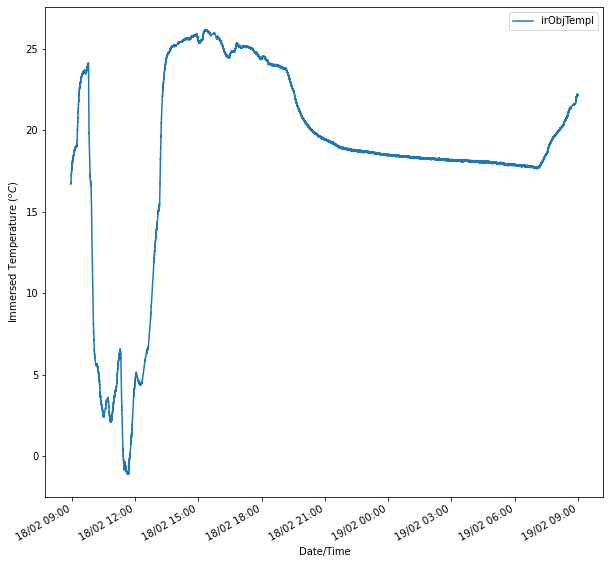

In [115]:
# === Plot irObjTempI data ===
sensor_plot_label = "Immersed Temperature ($^oC$)" # assume celsius, defintely not kelvin (<0)
fig = plot_sensor_data(df_sensor_data[sensor_name], sensor_plot_label)

4. Compute the rolling median of the immersed temperature, with a window of 30 seconds, and plot it.
Overlay the rolling median of the immersed UVA trace (`uvaI`) on the same plot.

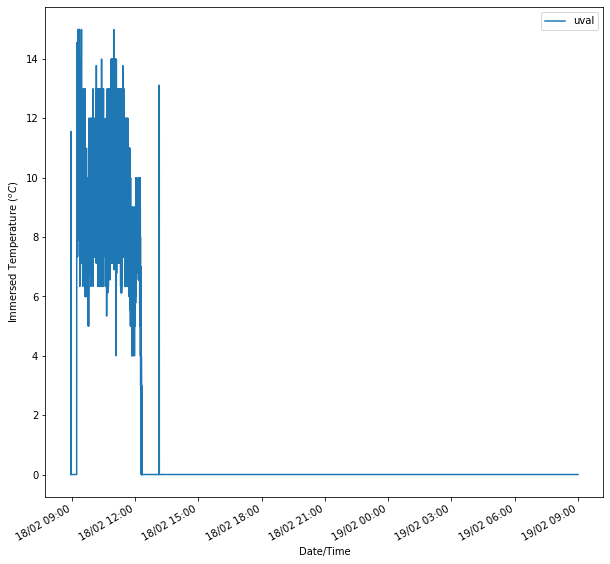

In [116]:
# === Get UvaI data ===
sensor_name = "uvaI"
df_sensor_data[sensor_name] = extract_sensor_data(file_path, sensor_name, stop_after_first)
fig = plot_sensor_data(df_sensor_data[sensor_name], sensor_plot_label)

In [117]:
# === Calculate rolling medians ===
rolling_window = 30 # rolling window size in seconds
sensor_names = ["irObjTempI",  "uvaI"]

for sensor_name in sensor_names:
    df_sensor_data[sensor_name][f"{sensor_name} - rolling_median"] = df_sensor_data[sensor_name][sensor_name].rolling(f'{rolling_window}s').median()

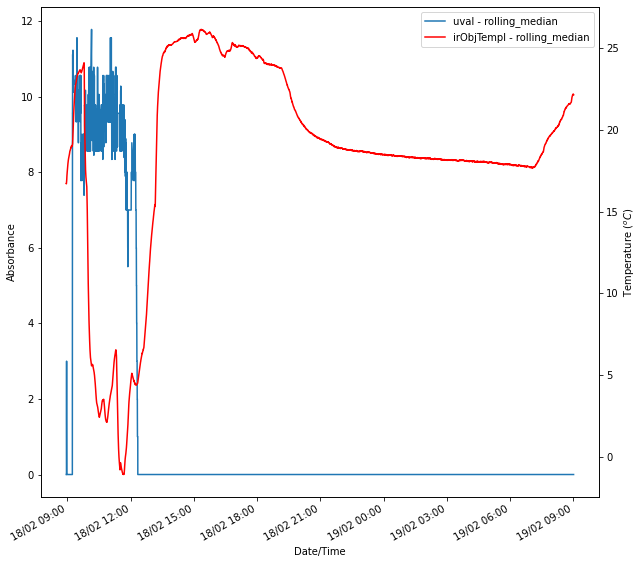

In [118]:
# === Plot uvaI and irObjTempI Side by Side ===
fig = plot_sensor_data(df_sensor_data["uvaI"][f"uvaI - rolling_median"], 
    "Absorbance",
    df_sensor_data["irObjTempI"][f"irObjTempI - rolling_median"],
    "Temperature ($^oC$)")

## Task 2 - Reaction Data

While PCRR is used as a means of encapsulating chemistry runs in DigitalGlassware, the concept
 of using XML as a structuring mechanism is quite recent. There are many older datasets which
 use formats such as RDF, wherein lists of reactions describe the structural change which
 occurs during the chemistry. This section will focus on a small sample dataset which uses
 this format

To perform this task, install [RDKit](https://www.rdkit.org) to your Anaconda environment.

An RD file has been provided under the `data` directory for use in the following tasks.

1. Write a parser to split up `data/spresi-100.rdf` into `$RXN` blocks, which
denote individual reactions. A valid reaction starts with `$RXN` and includes
every subsequent line until the next `$RXN` block (inclusive) or the
end of the file.
Everything before the first `$RXN` block can be ignored.
<p>
Alternatively, there is a Python library which will do this for you, but it's up to you
to find it.


In [119]:
import numpy as np
from typing import List

def extract_reactions_with_numpy(file_path:str): # -> List[str]:
    # This was a nice idea but it does a lot to mess up the formatting of the file when we convert the array back a string
    # might be fixable
    """Extracts the reactions from a .rdf file and returns them as a list of strings."""

    section_seperator = "$RXN"
    rxn_blocks = [] # this will store each extracted reaction block

    # === Parse File ===
    with open(file_path, "r") as f:
        lines = f.read().splitlines() # read all lines into a list

    lines = np.array(lines) # convert lines list to a numpy array
    rxn_block_idxs = np.where(lines == section_seperator) # find all instances $RXN and save as np array
    num_reactions = np.shape(rxn_block_idxs)[1] - 1

    # === Extract Reactions ===
    for ii in range(num_reactions):
        # iterate over the found $RXN tags
        rxn_block_start = rxn_block_idxs[0][ii] # Get index of block start - each block starts on line with $RXN
        rxn_block_end = rxn_block_idxs[0][ii+1] - 1 # Get index of block end - block ends one line before the next $RXN
        
        rxn_block = lines[rxn_block_start:rxn_block_end] # retreive all lines of this reaction
        rxn_block = np.array2string(rxn_block, 
                                    separator="\n")
                                    #formatter={"str_kind": lambda x: "%s " % x}) # convert array back to a string
        
        rxn_block = rxn_block[1:-1] # remove leading and trailing "[" and "]"
        rxn_blocks.append(rxn_block)
    
    return rxn_blocks

def extract_reactions(file_path:str): # -> List[str]:
    """Extracts the reactions from a .rdf file and returns them as a list of strings."""

    section_seperator = "$RXN"
    rxn_blocks = [] # this will store each extracted reaction block
    rxn_block = "" # temporarily storos individual reaction blocks while they are parsed
    in_header = True # indicates if we are in the header of the file - we ignore the header
    eof = False # indicates if we are at the end of the file

    # === Parse File ===
    with open(file_path, "r") as f:
        while eof == False:
            line = f.readline()

            if line == "":
                eof = True

            if line == f"{section_seperator}\n":
                if in_header == True: 
                    in_header = False # if we are here, we have found the first reaction block
                else:
                    rxn_blocks.append(rxn_block) # append the previous block to the list of reactions
                    rxn_block = "" # start a new block
            
            if in_header == False:
                rxn_block += line

    return rxn_blocks

file_path = "../data/spresi-100.rdf"
rxn_blocks = extract_reactions(file_path)
print(f"Found {len(rxn_blocks)+1} reactions.")

Found 100 reactions.


2. Use RDKit to parse each of the `$RXN` text blocks you parsed in above,
 and print out the SMILES for the reagents and products
 on the first 5 reactions.


In [120]:
from rdkit.Chem import rdChemReactions
from rdkit import Chem
# rdChemReactions - https://www.rdkit.org/docs/source/rdkit.Chem.rdChemReactions.html

def get_molecules_from_rxn(rxn:str):
    products = rxn.GetProducts()
    reactants = rxn.GetReactants()
    molecule_types = [] # stores whether the molecules is a reagant or product
    molecules = [] # list of RDkit mol objects
    for jj, reactant in enumerate(reactants):
        print(f"Reactant {jj+1}: ", end="")
        print("{mol_type} {idx}: ".format(mol_type="Reactant", idx=jj+1), end="")
        print(Chem.MolToSmiles(reactant))
        molecules.append(reactant)
        molecule_types.append("reactant")


    for jj, product in enumerate(products):
        print(f" Product {jj+1}: ", end="")
        print(Chem.MolToSmiles(product))
        molecules.append(product)
        molecule_types.append("product")

    return molecules, molecule_types

max_reactions = 5
molecules = [] # rdkit mol objects from all rxn blocks
molecule_types = [] # product/reactant for each molecule
for ii in range(max_reactions):
    print(f"----- Reaction {ii+1} -----")
    rxn = rdChemReactions.ReactionFromRxnBlock(rxn_blocks[ii])

    rxn_molecules, rxn_molecule_types = get_molecules_from_rxn(rxn)

    molecules += rxn_molecules
    molecule_types += rxn_molecule_types

----- Reaction 1 -----
Reactant 1: Reactant 1: O=S(C1=CC=CC=C1)[CH:2]1[C:1]2([O:3]1)[CH2:4][CH2:7][CH:11]([C:14]([CH3:17])([CH3:18])[CH3:19])[CH2:8][CH2:5]2
Reactant 2: Reactant 2: O=Cl(=O)(=O)[O-].[Li+]
Reactant 3: Reactant 3: CCCCP(=O)(CCCC)CCCC
 Product 1: [C:1]1([CH:2]=[O:3])=[CH:4][CH2:7][CH:11]([C:14]([CH3:17])([CH3:18])[CH3:19])[CH2:8][CH2:5]1
----- Reaction 2 -----
Reactant 1: Reactant 1: [H][C@:2]12[C@@:1]([CH3:5])([CH:3]([C@@:9]([H])([CH2:13][CH2:17][CH2:21][CH:24]([CH3:26])[CH3:27])[CH3:14])[CH2:8][CH2:7]1)[CH2:4][CH2:10][C@@:11]1([H])[C@@:6]2([H])[CH2:12][CH2:16][C@:18]2([H])[C@:15]1([CH3:20])[CH2:19][CH2:23][C:25]([CH:28](Cl)[S:30]([C:32]1=[CH:34][CH:36]=[CH:38][CH:37]=[CH:35]1)=[O:33])([OH:29])[CH2:22]2
Reactant 2: Reactant 2: [H][O-].[K+]
 Product 1: [H][C@:2]12[C@@:1]([CH3:5])([CH:3]([C@@:9]([H])([CH2:13][CH2:17][CH2:21][CH:24]([CH3:26])[CH3:27])[CH3:14])[CH2:8][CH2:7]1)[CH2:4][CH2:10][C@@:11]1([H])[C@@:6]2([H])[CH2:12][CH2:16][C@:18]2([H])[C@:15]1([CH3:20])[CH2:19][CH2

2. Generate [molecular fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints)
for all reagents and products and store them in a binary numpy matrix (bonus: use a sparse matrix).
Use a radius of 2 and fingerprint length of 1000. Ignore any molecules which throw an exception, and remove them from
the final array.

In [130]:
from rdkit.Chem.Draw.SimilarityMaps import GetMorganFingerprint
from rdkit.DataStructs import cDataStructs
from scipy.sparse import csr_matrix
from rdkit.Chem.rdchem import Mol


def get_molecular_fingerprints(molecules: List[Mol], nbits: int, sparse_matrix: bool = True): # -> Union[np.array, csr_matrix]:

    fingerprints = np.zeros((len(molecules),nbits), dtype=np.int8) # intitialize numpy array for fingerprints
    for ii, m in enumerate(molecules):
        try:
            Chem.SanitizeMol(m) # exception in GetMorganFingerprint() without this
            fp = GetMorganFingerprint(m, 2, nBits=1000)

        except:
            print(f"Failed to get fingerprint for molecule {ii}.")

        else:
            arr = np.zeros((0,), dtype=np.int8) # intitialize target numpy array
            cDataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints[ii] = arr
    
    if sparse_matrix:
        fingerprints = csr_matrix(fingerprints) # convert to sparse matrix

    return fingerprints


nbits = 1000
fingerprints = get_molecular_fingerprints(molecules, nbits)

# refs
# convert to numpy - https://iwatobipen.wordpress.com/2019/02/08/convert-fingerprint-to-numpy-array-and-conver-numpy-array-to-fingerprint-rdkit-memorandum/
# rdkit data structure - https://www.rdkit.org/docs/source/rdkit.DataStructs.cDataStructs.html
# sparse matrix - https://machinelearningmastery.com/sparse-matrices-for-machine-learning/

3. Perform dimensionality reduction on the fingerprints to visualise the data in 2D.
Use whether the molecule's fingerprint was a reactant or product as the colour of the point.

<BarContainer object of 15 artists>

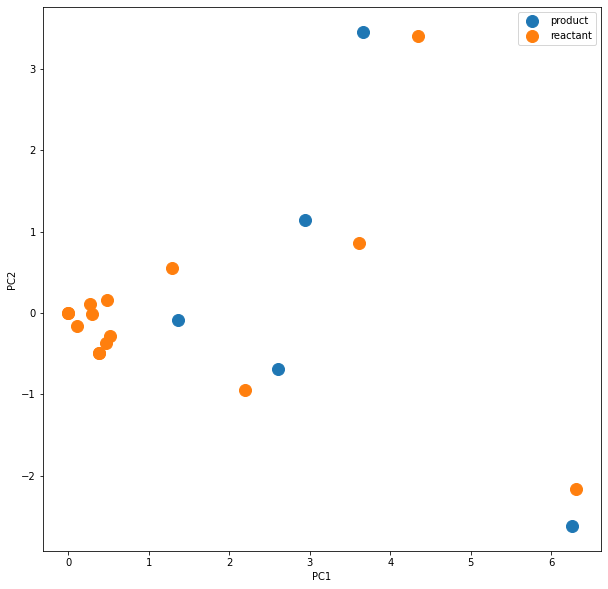

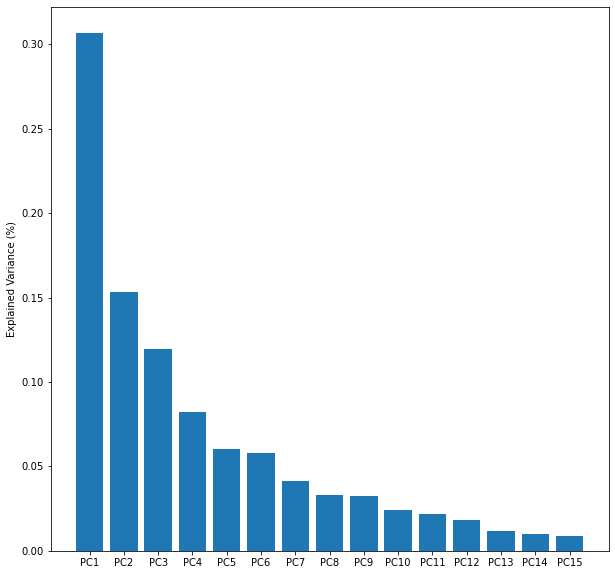

In [122]:
from sklearn.decomposition import TruncatedSVD

num_components = 15
columns = [f"PC{x+1}" for x in range(0,num_components)] # assign column names for the principal components


# === Perform Dimentionality Reduction ===
tSVD = TruncatedSVD(num_components) # tSVD rather than PCA for sparse matrix
fingerprints_tSVD = tSVD.fit_transform(fingerprints)

# === Convert to Dataframe ===
df_fingerprints_tSVD = pd.DataFrame(fingerprints_tSVD, columns=columns)
df_fingerprints_tSVD["molecule_type"] = molecule_types
df_fingerprints_tSVD["molecule_type"] = df_fingerprints_tSVD["molecule_type"].astype("category")

# === Plot 2D Scatterplot ===
fig_scatter, ax_scatter = plt.subplots(figsize=figsize)
groups = df_fingerprints_tSVD.groupby('molecule_type') # group by the molecule type
for name, group in groups: # plot each group (reactant/product) - matplotlib will give them different colors
    fig = plt.plot(group[columns[0]], group[columns[1]], marker='o', linestyle='', markersize=12, label=name)

ax_scatter.legend()
ax_scatter.set_xlabel(columns[0])
ax_scatter.set_ylabel(columns[1])

fig_scatter

# === Scree Plot ===
fig_scree, ax_scree = plt.subplots(figsize=figsize)

scree = tSVD.explained_variance_ratio_
fig_scree = plt.bar(x=range(0,num_components), height=scree, tick_label=columns)
ax_scree.set_ylabel("Explained Variance (%)")

fig_scree

Perform clustering on the fingerprints and visualise the results in the same embedding used
in the previous question.

## Wrap Up

Please bring the completed code in this notebook/code for generating results along to your interview.
The code should be executed in real-time unless there is a good reason to avoid this. You will be
asked how you completed the tasks and why you did it a certain way, as well as discussion
on other ways the tasks could have been performed.

